# Import Libraries

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  2


In [2]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
import tensorflow
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.utils import np_utils
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import os
from keras.models import Sequential
from sklearn import preprocessing
import math

# Data Preprocessing

In [4]:
csv_file = "denser_data_collection.csv" #"denser_data_collection_marker.csv" #"data_collection.csv"
columns = ['Serial_no','Timestamp', 'x_actual', 'y_actual', 'direction', 'x_step', 'y_step']
data_df = pd.read_csv(csv_file, header=None, names = columns)

serial_numbers = data_df['Serial_no'].astype(str).apply(lambda x: int(x.split(',')[0]))

image_folder = "output_images_denser" #"output_images_denser_marker" #"cropped_noedges_new" #"output_images_new" #"images_resized_500"

X = []
Y = []
Y_dir = []
Y_coords = []

le = preprocessing.LabelEncoder()
data_df['direction'] = le.fit_transform(data_df['direction'])


count_direction_0 = data_df[data_df['direction'] == 0].shape[0]
count_direction_1 = data_df[data_df['direction'] == 1].shape[0]


print("Number of rows with direction 0:", count_direction_0)
print("Number of rows with direction 1:", count_direction_1)



serial_numbers = set(data_df['Serial_no'])
date_time = data_df['Timestamp']
x_coordinate = data_df['x_actual']
y_coordinate = data_df['y_actual']
direction = data_df['direction']
x_step = data_df['x_step']
y_step = data_df['y_step']


image_files = os.listdir(image_folder)


contact = 1
non_contact = 0

for row in data_df.itertuples(index=False, name='data_df'):
    serial_number = row.Serial_no
    date_time = row.Timestamp
    x_coordinate = row.x_actual
    y_coordinate = row.y_actual
    direction = row.direction
    x_step = row.x_step
    y_step = row.y_step


    ############################## contact and right direction data only
    if (110 <= y_step <= 162) and (126 >= x_step >= 2): #Keeping only the trustworthy data for training
        if pd.notnull(x_coordinate) and pd.notnull(y_coordinate) and \
            direction == 1 and -12.5 <= x_coordinate <= 4.49:
                matching_files = [filename for filename in image_files if filename.startswith(str(serial_number))]
                if matching_files:
                    image_name = matching_files[0]  # Assuming there is only one matching file
                    image_path = os.path.join(image_folder, image_name)
                    image = cv2.imread(image_path)
                    # if image is not None: 
                    X.append(image)
                    Y_dir.append(direction) #only contact
                    Y.append(1)
                    Y_coords.append([x_coordinate, y_coordinate])




    ############################# contact and left direction data only
    if (148 <= y_step <= 204) and (126 >= x_step >= 2): #Keeping only the trustworthy data for training
        if pd.notnull(x_coordinate) and pd.notnull(y_coordinate) and \
            direction == 0 and -18.81 <= x_coordinate <= -3.075:
                matching_files = [filename for filename in image_files if filename.startswith(str(serial_number))]
                if matching_files:
                    image_name = matching_files[0]  # Assuming there is only one matching file
                    image_path = os.path.join(image_folder, image_name)
                    image = cv2.imread(image_path)
                    # if image is not None: 
                    X.append(image)
                    Y_dir.append(direction)
                    Y.append(1) #only contacts
                    Y_coords.append([x_coordinate, y_coordinate])


    elif pd.notnull(x_coordinate) and pd.notnull(y_coordinate) and \
        ((direction == 0 and (x_coordinate < -18.81 or x_coordinate > -3.075)) \
               or (direction == 1 and (x_coordinate > 4.49 or x_coordinate < -12.5))):
            matching_files = [filename for filename in image_files if filename.startswith(str(serial_number))]
            if matching_files:
                image_name = matching_files[0]  # Assuming there is only one matching file
                image_path = os.path.join(image_folder, image_name)
                image = cv2.imread(image_path)
                # if image is not None: 
                X.append(image)
                Y_dir.append(direction)
                Y.append(0) #only non-contact
                Y_coords.append([x_coordinate, y_coordinate])


Number of rows with direction 0: 7853
Number of rows with direction 1: 7857


In [38]:
# Print the mapping of original labels to encoded labels
print("Original Direction Labels:", le.classes_)

Original Direction Labels: ['left' 'right']


In [126]:
count_0 = np.sum(Y_dir == 0)
count_1 = np.sum(Y_dir == 1)

print("Number of elements with value 0:", count_0)
print("Number of elements with value 1:", count_1)

Number of elements with value 0: 4551
Number of elements with value 1: 4586


In [5]:
print(data_df.shape)

(15710, 7)


In [5]:
print(len(X))
print(len(Y))
print(len(Y_dir))
print(len(Y_coords))

9137
9137
9137
9137


In [7]:
print(data_df['direction'].isnull().sum())

0


In [1]:
!nvidia-smi # A command to view the NVIDIA GPU details (especially to view the memory usage while running the code)

Mon Aug 28 10:46:12 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.05              Driver Version: 535.86.05    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX 6000 Ada Gene...    On  | 00000000:41:00.0 Off |                  Off |
| 30%   40C    P8              28W / 300W |      4MiB / 49140MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
# data = list(zip(imagess, parsed_custom_info))
data = list(zip(X, Y, Y_dir, Y_coords))

In [6]:
from keras.backend import set_session

<b>Note</b>: the next two blocks of code and the block of code towards the end where the session is closed was \
used to clear GPU memory. \
<b>Reference</b>: https://saturncloud.io/blog/how-to-clear-tensorflow-gpu-memory-after-model-execution/
\
<br>
<b>Important</b>: It is no longer necessary to use these three blocks of code. \
<b>A way round this problem</b>: Just refresh the kernel of the notebook once (a few times if necessary) \
to ensure the GPU memory gets cleared. 

In [7]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [8]:
config = tf.ConfigProto()
# config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
set_session(sess)


In [9]:
# Shuffle the dataset
np.random.shuffle(data)

X = [item[0] for item in data]
Y = [item[1] for item in data]
Y_dir = [item[2] for item in data]
Y_coords = [item[3] for item in data]

In [10]:
X = np.array(X)

In [11]:
X = X.astype('float32')

In [12]:
X /= 255

In [13]:
Y = np.array(Y)
Y_dir = np.array(Y_dir)
Y_coords = np.array(Y_coords)

In [16]:
print("Shape X: ", np.shape(X))
print("Shape Y: ", np.shape(Y))
print("Shape Y_dir: ", np.shape(Y_dir))
print("Shape Y_coords: ", np.shape(Y_coords))

Shape X:  (9137, 1080, 1920, 3)
Shape Y:  (9137,)
Shape Y_dir:  (9137,)
Shape Y_coords:  (9137, 2)


# ############################

In [14]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Defining model architectures of the 4 models

In [15]:
def classification_direction_model():
    num_classes = 2 # number of classes for classification

    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(1080, 1920, 3), kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(Dense(num_classes, activation='softmax'))  # Output layer with softmax for classification

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])  # Using categorical_crossentropy since classification

    return model


def classification_contactnocontact_model():
    num_classes = 2 # number of classes for classification

    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(1080, 1920, 3), kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(Dense(num_classes, activation='softmax'))  # Output layer with softmax for classification

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])  # Using categorical_crossentropy since classification

    return model


def regression_coordinates_model_left():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(1080, 1920, 3), kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(Dense(2))  # Output layer with 2 units for regression

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

def regression_coordinates_model_right():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(1080, 1920, 3), kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(Dense(2))  # Output layer with 2 units for regression

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Loading the desired checkpoints 
Note: The checkpoint is selected based on the performance of the respective model on train and test data.

In [16]:
import os

checkpoint_directory_contactnoncontact = "checkpoints_classification_neww_onlytrustworthycontactnoncontact/"
checkpoint_directory_direction = "checkpoints_classification_direction_leftright/"
checkpoint_directory_left = "checkpoints_left_non_sus_data/"
checkpoint_directory_right = "checkpoints_right_non_sus_data/"

In [17]:
# Create an instance of the model
model_1 = classification_contactnocontact_model()
model_2 = classification_direction_model()
model_3_left= regression_coordinates_model_left()
model_3_right = regression_coordinates_model_right()

# Pick the weights here
checkpoint_name_1 = "weights_epoch_0015.ckpt"
checkpoint_name_2 = "weights_epoch_0040.ckpt"
checkpoint_name_3_left = "weights_epoch_0200.ckpt"
checkpoint_name_3_right = "weights_epoch_0200.ckpt"


# Complete checkpoint paths
checkpoint_path_1 = os.path.join(checkpoint_directory_contactnoncontact, checkpoint_name_1)
checkpoint_path_2 = os.path.join(checkpoint_directory_direction, checkpoint_name_2)
checkpoint_path_3_left = os.path.join(checkpoint_directory_left, checkpoint_name_3_left)
checkpoint_path_3_right = os.path.join(checkpoint_directory_right, checkpoint_name_3_right)

model_1.load_weights(checkpoint_path_1)
model_2.load_weights(checkpoint_path_2)
model_3_left.load_weights(checkpoint_path_3_left)
model_3_right.load_weights(checkpoint_path_3_right)

2023-08-28 10:50:49.835766: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_6/bias/Assign' id:685 op device:{requested: '', assigned: ''} def:{{{node dense_6/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_6/bias, dense_6/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [22]:
# sample_data = X[9]
sample_data = X

In [18]:
contact_prediction =  model_1.predict(X)

/usr/lib/python3/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-08-28 10:50:58.500273: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_1/Softmax' id:111 op device:{requested: '', assigned: ''} def:{{{node dense_1/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-08-28 10:50:59.234122: W tensorflow/core/kernels/gpu_utils.cc:50] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed onc

In [29]:
# print(contact_prediction)

[[9.6103561e-01 3.8964346e-02]
 [9.9592543e-01 4.0745586e-03]
 [9.9999595e-01 4.0798950e-06]
 ...
 [9.4884920e-01 5.1150806e-02]
 [9.6293521e-01 3.7064821e-02]
 [9.5101476e-01 4.8985299e-02]]


In [23]:
# print(contact_prediction[0])

NameError: name 'contact_prediction' is not defined

In [26]:
print(Y[0])

1


# Making predictions!! :)

In [114]:
#############################################################################################################################
specific_index = 5145

# specific_contact_prediction = contact_prediction[specific_index]

# Check the confidence for "contact" for the specific index
if contact_prediction[specific_index][0] < 0.75 and Y[specific_index] == 1:
    print('contact')
    direction_prediction = model_2.predict(np.expand_dims(X[specific_index], axis=0))
    
    if direction_prediction[0][0] >= 0.5:
        print("Left Direction")
        regression_model = model_3_left
    else:
        print("Right Direction")
        regression_model = model_3_right
        
    # Make regression prediction for x,y coordinates
    regression_prediction = regression_model.predict(np.expand_dims(X[specific_index], axis=0))
    predicted_x = regression_prediction[0][0]
    predicted_y = regression_prediction[0][1]

    print("Predicted Coordinates: (x={}, y={})".format(predicted_x, predicted_y))
    print(Y_coords[specific_index])
else:
    print("Object is not in contact with whisker array")

contact
Left Direction
Predicted Coordinates: (x=-4.014835834503174, y=-30.15424919128418)
[ -3.54631213 -28.39634621]


In [19]:
import numpy as np

In [112]:
occurrence_number = 900  # Change this to the desired occurrence number
indices_of_1 = np.where(Y == 1)[0]

if len(indices_of_1) >= occurrence_number:
    index_of_third_1 = indices_of_1[occurrence_number - 1]
    print("Index of the occurrence of 1:", index_of_third_1)
else:
    print("There are not enough occurrences of 1.") #Note: 1 means contact

Index of the occurrence of 1: 5145


In [25]:
contact_prediction = model_1.predict(X)

/usr/lib/python3/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-08-24 08:19:26.068767: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_1/Softmax' id:111 op device:{requested: '', assigned: ''} def:{{{node dense_1/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-08-24 08:19:26.959515: W tensorflow/core/kernels/gpu_utils.cc:50] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed onc

In [90]:
specific_index = 120

specific_contact_prediction = contact_prediction[specific_index]
print(Y[specific_index])
print(specific_contact_prediction)
# Check the confidence for "contact" for the specific index
if specific_contact_prediction[1] >= 0.75:
    print('contact')
    direction_prediction = model_1.predict(np.expand_dims(X[specific_index], axis=0))
    
    if direction_prediction[0][0] >= 0.75:
        print("Left Direction")
        regression_model = model_3_left
    else:
        print("Right Direction")
        regression_model = model_3_right
        
    # Make regression prediction for x,y coordinates
    regression_prediction = regression_model.predict(np.expand_dims(X[specific_index], axis=0))
    predicted_x = regression_prediction[0][0]
    predicted_y = regression_prediction[0][1]
    print(Y_coords[specific_index])

    print("Predicted Coordinates: (x={} cm, y={} cm)".format(predicted_x, predicted_y))
else:
    print("Object is not in contact with whisker array")

1
[0.00639051 0.99360955]
contact
Right Direction
Predicted Coordinates: (x=-9.977343559265137 cm, y=-28.286212921142578 cm)


In [104]:
specific_index = 0

specific_contact_prediction = contact_prediction[specific_index]

# Check the confidence for "contact" for the specific index
if (contact_prediction[specific_index][0]) < 0.75:
    print('contact')
    direction_prediction = model_2.predict(np.expand_dims(X[specific_index], axis=0))
    
    if direction_prediction[0][0] >= 0.75:
        print("Left Direction")
        regression_model = model_3_left
    else:
        print("Right Direction")
        regression_model = model_3_right
        
    # Make regression prediction for x,y coordinates
    regression_prediction = regression_model.predict(np.expand_dims(X[specific_index], axis=0))
    print(regression_prediction.shape)
    predicted_x = regression_prediction[0][0]
    predicted_y = regression_prediction[0][1]

    print("Predicted Coordinates: (x={}, y={})".format(predicted_x, predicted_y))
    print(Y_coords[15])
else:
    print("Object is not in contact with whisker array")

contact
Right Direction
(1, 2)
Predicted Coordinates: (x=-8.7318696975708, y=-23.988882064819336)
[  5.14381162 -30.29149137]


# Evaluation

In [20]:
import numpy as np
import matplotlib.pyplot as plt

## For contact/noncontact checking correct and incorrect predictions

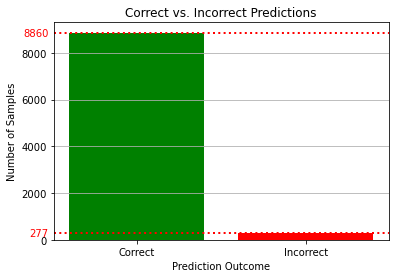

In [27]:
correct_predictions = 0
incorrect_predictions = 0
correct_indices = []
incorrect_indices = []

for i in range(len(X)):
    true_label = Y[i]
    predicted_class = np.argmax(contact_prediction[i]) #returns index
    
    if predicted_class == true_label:
        correct_predictions += 1
        correct_indices.append(i)

    else:
        incorrect_predictions += 1
        incorrect_indices.append(i)

# Create a bar graph
labels = ['Correct', 'Incorrect']
values = [correct_predictions, incorrect_predictions]

plt.bar(labels, values, color=['green', 'red'])
plt.xlabel('Prediction Outcome')
plt.ylabel('Number of Samples')
plt.title('Correct vs. Incorrect Predictions')
plt.grid(axis='y')
# Add a vertical line through the maximum value of incorrect class
plt.axhline(y=max(values), color='red', linestyle=':', label='Max Incorrect', linewidth=2)
plt.axhline(y=incorrect_predictions, color='red', linestyle=':', label='Max Incorrect', linewidth=2)

# Add text labels for the red lines' values on the y-axis
plt.text(-0.52, incorrect_predictions, str(incorrect_predictions), va='center', ha='right', color='red')
plt.text(-0.52, max(values), str(max(values)), va='center', ha='right', color='red')

plt.show()


## For direction checking correct and incorrect predictions

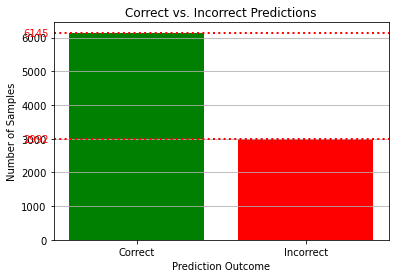

In [37]:
correct_predictions = 0
incorrect_predictions = 0
correct_indices = []
incorrect_indices = []

for i in range(len(X)):
    true_label = Y_dir[i]
    predicted_class = np.argmax(direction_prediction[i]) #returns index
    
    if predicted_class == true_label:
        correct_predictions += 1
        correct_indices.append(i)

    else:
        incorrect_predictions += 1
        incorrect_indices.append(i)

# Create a bar graph
labels = ['Correct', 'Incorrect']
values = [correct_predictions, incorrect_predictions]

plt.bar(labels, values, color=['green', 'red'])
plt.xlabel('Prediction Outcome')
plt.ylabel('Number of Samples')
plt.title('Correct vs. Incorrect Predictions')
plt.grid(axis='y')
# Add a vertical line through the maximum value of incorrect class
plt.axhline(y=max(values), color='red', linestyle=':', label='Max Incorrect', linewidth=2)
plt.axhline(y=incorrect_predictions, color='red', linestyle=':', label='Max Incorrect', linewidth=2)

# Add text labels for the red lines' values on the y-axis
plt.text(-0.52, incorrect_predictions, str(incorrect_predictions), va='center', ha='right', color='red')
plt.text(-0.52, max(values), str(max(values)), va='center', ha='right', color='red')

plt.show()


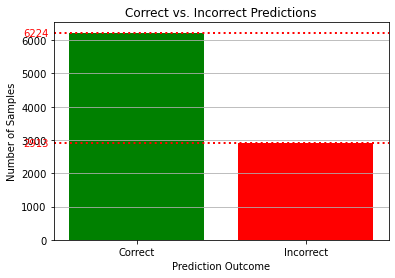

In [124]:
correct_predictions = 0
incorrect_predictions = 0
correct_indices = []
incorrect_indices = []

for i in range(len(X)):
    true_label = Y_dir[i]
    predicted_class = np.argmax(direction_prediction[i]) #returns index
    
    if predicted_class == true_label:
        correct_predictions += 1
        correct_indices.append(i)

    else:
        incorrect_predictions += 1
        incorrect_indices.append(i)

# Create a bar graph
labels = ['Correct', 'Incorrect']
values = [correct_predictions, incorrect_predictions]

plt.bar(labels, values, color=['green', 'red'])
plt.xlabel('Prediction Outcome')
plt.ylabel('Number of Samples')
plt.title('Correct vs. Incorrect Predictions')
plt.grid(axis='y')
# Add a vertical line through the maximum value of incorrect class
plt.axhline(y=max(values), color='red', linestyle=':', label='Max Incorrect', linewidth=2)
plt.axhline(y=incorrect_predictions, color='red', linestyle=':', label='Max Incorrect', linewidth=2)

# Add text labels for the red lines' values on the y-axis
plt.text(-0.52, incorrect_predictions, str(incorrect_predictions), va='center', ha='right', color='red')
plt.text(-0.52, max(values), str(max(values)), va='center', ha='right', color='red')

plt.show()

In [32]:
direction_prediction = model_2.predict(X)

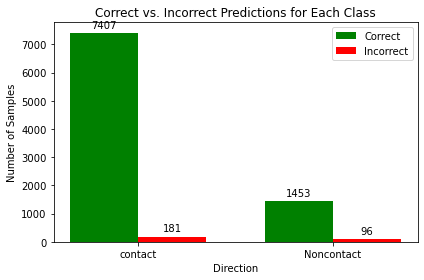

In [33]:
# Calculate counts of correct and incorrect predictions for each class

correct_counts = [len([i for i in correct_indices if Y[i] == class_idx]) for class_idx in range(2)]
incorrect_counts = [len([i for i in incorrect_indices if Y[i] == class_idx]) for class_idx in range(2)]

# Create a bar graph with grouped bars
bar_width = 0.35
index = np.arange(2)

fig, ax = plt.subplots()
correct_bars = ax.bar(index, correct_counts, bar_width, label='Correct', color='green')
incorrect_bars = ax.bar(index + bar_width, incorrect_counts, bar_width, label='Incorrect', color='red')

ax.set_xlabel('Direction')
ax.set_ylabel('Number of Samples')
ax.set_title('Correct vs. Incorrect Predictions for Each Class')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('contact', 'Noncontact'))
ax.legend()

# Add text labels on top of the bars
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(correct_bars)
autolabel(incorrect_bars)

plt.tight_layout()
plt.show()

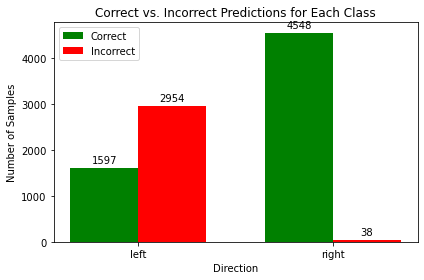

In [38]:
# correct_predictions = 0
# incorrect_predictions = 0
# correct_indices = []
# incorrect_indices = []

# Calculate counts of correct and incorrect predictions for each class

correct_counts = [len([i for i in correct_indices if Y_dir[i] == class_idx]) for class_idx in range(2)]
incorrect_counts = [len([i for i in incorrect_indices if Y_dir[i] == class_idx]) for class_idx in range(2)]

# Create a bar graph with grouped bars
bar_width = 0.35
index = np.arange(2)

fig, ax = plt.subplots()
correct_bars = ax.bar(index, correct_counts, bar_width, label='Correct', color='green')
incorrect_bars = ax.bar(index + bar_width, incorrect_counts, bar_width, label='Incorrect', color='red')

ax.set_xlabel('Direction')
ax.set_ylabel('Number of Samples')
ax.set_title('Correct vs. Incorrect Predictions for Each Class')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('left', 'right'))
ax.legend()

# Add text labels on top of the bars
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(correct_bars)
autolabel(incorrect_bars)

plt.tight_layout()
plt.show()

In [102]:
print(correct_indices[0])

0


In [100]:
print(correct_indices[1])

1


In [103]:
print(incorrect_indices[0])

44


In [101]:
print(incorrect_indices[1])

49


In [ ]:
correct_predictions = 0
incorrect_predictions = 0

for i in range(len(X)):
    true_label = Y[i]
    predicted_class = np.argmax(contact_prediction[i])
    
    if predicted_class == true_label:
        correct_predictions += 1
    else:
        incorrect_predictions += 1

# Create a bar graph
labels = ['Correct', 'Incorrect']
values = [correct_predictions, incorrect_predictions]

plt.bar(labels, values, color=['green', 'red'])
plt.xlabel('Prediction Outcome')
plt.ylabel('Number of Samples')
plt.title('Correct vs. Incorrect Predictions')
plt.grid(axis='y')
# Add a vertical line through the maximum value of incorrect class
plt.axhline(y=max(values), color='red', linestyle=':', label='Max Incorrect', linewidth=2)
plt.axhline(y=incorrect_predictions, color='red', linestyle=':', label='Max Incorrect', linewidth=2)

# Add text labels for the red lines' values on the y-axis
plt.text(-0.52, incorrect_predictions, str(incorrect_predictions), va='center', ha='right', color='red')
plt.text(-0.52, max(values), str(max(values)), va='center', ha='right', color='red')

plt.show()

In [25]:
color_palette = ['blue', 'red', 'green', 'purple', 'orange', 'pink', 'cyan', 'yellow', 'brown', 'gray']


In [73]:
# ! pip install plotly

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 55.1 MB/s eta 0:00:0000:0100:01


*******************************

In [21]:
import pandas as pd
import plotly.express as px

In [44]:
confidence_ranges = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
confidence_counts_contact = [0] * (len(confidence_ranges) - 1)
confidence_counts_non_contact = [0] * (len(confidence_ranges) - 1)

correct_samples_indices = []

for i in range(len(X)):
    true_label = Y[i]
    confidence = contact_prediction[i][true_label] * 100  # Convert to percentage

    # if np.argmax(contact_prediction[i]) == true_label: #only if the prediction was correct
    #     correct_samples_indices.append(i)
    
    for j in range(len(confidence_ranges) - 1):
        if confidence_ranges[j] <= confidence < confidence_ranges[j + 1]:
            if true_label == 1:
                confidence_counts_contact[j] += 1
            else:
                confidence_counts_non_contact[j] += 1
            break
labels = [f"{low}-{high}" for low, high in zip(confidence_ranges[:-1], confidence_ranges[1:])]

# Create DataFrame for contact class
contact_confidence_counts_df = pd.DataFrame({
    'Range': labels,
    'Contact': confidence_counts_contact,
})

# Create DataFrame for non-contact class
noncontact_confidence_counts_df = pd.DataFrame({
    'Range': labels,
    'Non-Contact': confidence_counts_non_contact,
})

# Melt the DataFrames
melted_contact_df = pd.melt(contact_confidence_counts_df, id_vars=['Range'], var_name='Class', value_name='Value')
melted_noncontact_df = pd.melt(noncontact_confidence_counts_df, id_vars=['Range'], var_name='Class', value_name='Value')

# Define a custom color palette
color_palette = ['blue', 'red', 'green', 'purple', 'orange', 'pink', 'cyan', 'yellow', 'brown', 'gray']

# Create the pie chart for contact class
contact_fig = px.pie(
    melted_contact_df,
    values='Value',
    names='Range',
    title='Predicted Contact',
    color='Range',
    color_discrete_sequence=color_palette,
    template='plotly',
    width=600,
    height=500,
)
contact_fig.update_traces(rotation=20)  # Rotate the pie chart
contact_fig.update_layout(
    legend_orientation='v',
    legend_title_text='Confidence Ranges',
    legend_x=1.1,
    legend_y=0.5,
)

# Create the pie chart for non-contact class
non_contact_fig = px.pie(
    melted_noncontact_df,
    values='Value',
    names='Range',
    title='Predicted Non-Contact',
    color='Range',
    color_discrete_sequence=color_palette,
    template='plotly',
    width=600,
    height=500,
)
non_contact_fig.update_traces(rotation=20)  # Rotate the pie chart
non_contact_fig.update_layout(
    legend_orientation='v',
    legend_title_text='Confidence Ranges',
    legend_x=1.1,
    legend_y=0.5,
)

# Show the plots
contact_fig.show()
non_contact_fig.show()


In [46]:
confidence_ranges = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
confidence_counts_contact = [0] * (len(confidence_ranges) - 1)
confidence_counts_non_contact = [0] * (len(confidence_ranges) - 1)

correct_samples_indices = []

for i in range(len(X)):
    true_label = Y[i]
    confidence = contact_prediction[i][true_label] * 100  # Convert to percentage

    if np.argmax(contact_prediction[i]) == true_label: #only if the prediction was correct
        correct_samples_indices.append(i)
    
        for j in range(len(confidence_ranges) - 1):
            if confidence_ranges[j] <= confidence < confidence_ranges[j + 1]:
                if true_label == 1:
                    confidence_counts_contact[j] += 1
                else:
                    confidence_counts_non_contact[j] += 1
                break
labels = [f"{low}-{high}" for low, high in zip(confidence_ranges[:-1], confidence_ranges[1:])]

# Create DataFrame for contact class
contact_confidence_counts_df = pd.DataFrame({
    'Range': labels,
    'Contact': confidence_counts_contact,
})

# Create DataFrame for non-contact class
noncontact_confidence_counts_df = pd.DataFrame({
    'Range': labels,
    'Non-Contact': confidence_counts_non_contact,
})

# Melt the DataFrames
melted_contact_df = pd.melt(contact_confidence_counts_df, id_vars=['Range'], var_name='Class', value_name='Value')
melted_noncontact_df = pd.melt(noncontact_confidence_counts_df, id_vars=['Range'], var_name='Class', value_name='Value')

# Define a custom color palette
color_palette = ['blue', 'red', 'green', 'purple', 'orange', 'pink', 'cyan', 'yellow', 'brown', 'gray']

# Create the pie chart for contact class
contact_fig = px.pie(
    melted_contact_df,
    values='Value',
    names='Range',
    title='Predicted Contact',
    color='Range',
    color_discrete_sequence=color_palette,
    template='plotly',
    width=600,
    height=500,
)
contact_fig.update_traces(rotation=20)  # Rotate the pie chart
contact_fig.update_layout(
    legend_orientation='v',
    legend_title_text='Confidence Ranges',
    legend_x=1.1,
    legend_y=0.5,
)

# Create the pie chart for non-contact class
non_contact_fig = px.pie(
    melted_noncontact_df,
    values='Value',
    names='Range',
    title='Predicted Non-Contact',
    color='Range',
    color_discrete_sequence=color_palette,
    template='plotly',
    width=600,
    height=500,
)
non_contact_fig.update_traces(rotation=20)  # Rotate the pie chart
non_contact_fig.update_layout(
    legend_orientation='v',
    legend_title_text='Confidence Ranges',
    legend_x=1.1,
    legend_y=0.5,
)

# Show the plots
contact_fig.show()
non_contact_fig.show()

In [45]:
confidence_ranges = [50, 60, 70, 80, 90, 100]
confidence_counts_contact = [0] * (len(confidence_ranges) - 1)
confidence_counts_non_contact = [0] * (len(confidence_ranges) - 1)

correct_samples_indices = []

for i in range(len(X)):
    true_label = Y[i]
    confidence = contact_prediction[i][true_label] * 100  # Convert to percentage

    if np.argmax(contact_prediction[i]) == true_label: #only if the prediction was correct
        correct_samples_indices.append(i)
    
        for j in range(len(confidence_ranges) - 1):
            if confidence_ranges[j] <= confidence < confidence_ranges[j + 1]:
                if true_label == 1:
                    confidence_counts_contact[j] += 1
                else:
                    confidence_counts_non_contact[j] += 1
                break

# Create pie charts for contact and non-contact classes
labels = [f"{low}-{high}" for low, high in zip(confidence_ranges[:-1], confidence_ranges[1:])]

data = {
    'Range': labels,
    'Contact': confidence_counts_contact,
}
data2 = {
    'Range': labels,
    'Non-Contact': confidence_counts_non_contact
}
contact_confidence_counts_df = pd.DataFrame(data)
noncontact_confidence_counts_df = pd.DataFrame(data2)


# Melt the DataFrame to have a single 'Value' column and a 'Class' column
melted_df = pd.melt(contact_confidence_counts_df, id_vars=['Range'], var_name='Class', value_name='Value')
melted_df2 = pd.melt(noncontact_confidence_counts_df, id_vars=['Range'], var_name='Class', value_name='Value')


# Define a custom color palette for each section of the pie chart
color_palette = ['blue', 'red', 'green', 'purple', 'orange', 'pink', 'cyan', 'yellow', 'brown', 'gray']

# Create the pie chart using Plotly Express
fig = px.pie(
    melted_df,
    values='Value',
    names='Range',
    title='Predicted Contact',
    color='Range',  # Color each section based on the 'Range' column
    color_discrete_sequence=color_palette,  # Use the custom color palette
    template='plotly',  # Use the "plotly" template for more control
    width=600,
    height=500,
)

# Rotate the pie chart by a specific angle (e.g., 20 degrees)
rotation_angle = 20
fig.update_traces(rotation=rotation_angle)

# Add a color legend on the side
fig.update_layout(
    legend_orientation='v',
    legend_title_text='Confidence Ranges',
    legend_x=1.1,
    legend_y=0.5,
)

fig.show()

In [48]:
# Create the pie chart using Plotly Express
fig = px.pie(
    melted_df2,
    values='Value',
    names='Range',
    title='Predicted Non-Contact',
    color='Range',  # Color each section based on the 'Range' column
    color_discrete_sequence=color_palette,  # Use the custom color palette
    template='plotly',  # Use the "plotly" template for more control
    width=600,
    height=500,
)

# Rotate the pie chart by a specific angle (e.g., 20 degrees)
rotation_angle = 20
fig.update_traces(rotation=rotation_angle)

# Add a color legend on the side
fig.update_layout(
    legend_orientation='v',
    legend_title_text='Confidence Ranges',
    legend_x=1.1,
    legend_y=0.5,
)

fig.show()

In [85]:
! pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 KB 13.5 MB/s eta 0:00:00


## Note: this below confusion matrix does not include suspicious data 

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

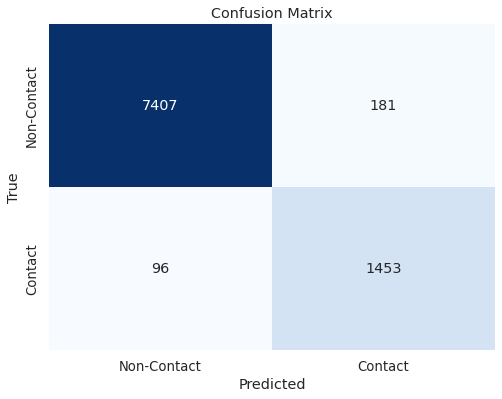

In [50]:
# Assuming contact_prediction contains the predicted probabilities for each sample

true_labels = Y  # True labels (ground truth)
predicted_labels = [np.argmax(pred) for pred in contact_prediction]  # Predicted labels (convert probabilities to labels)

confusion = confusion_matrix(true_labels, predicted_labels)

def plot_confusion_matrix(confusion_matrix, class_names, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

class_names = ['Non-Contact', 'Contact']
plot_confusion_matrix(confusion, class_names)


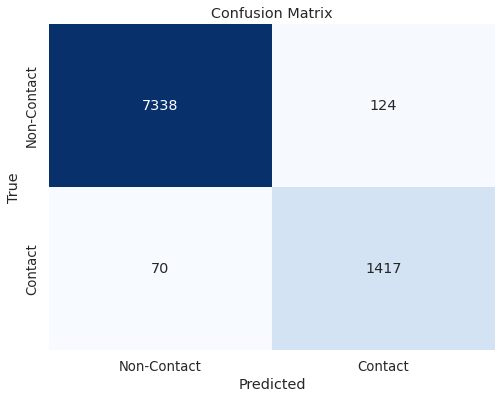

In [51]:
# Assuming contact_prediction contains the predicted probabilities for each sample

true_labels = Y  # True labels (ground truth)

# Create a list of indices for predictions with confidence >= 0.75
selected_indices = [i for i, pred in enumerate(contact_prediction) if np.max(pred) >= 0.75]

# Use the selected indices to create the filtered predicted labels
filtered_predicted_labels = [np.argmax(contact_prediction[i]) for i in selected_indices]

# Create the confusion matrix
confusion = confusion_matrix(true_labels[selected_indices], filtered_predicted_labels)

def plot_confusion_matrix(confusion_matrix, class_names, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

class_names = ['Non-Contact', 'Contact']
plot_confusion_matrix(confusion, class_names)


## Evaluation on STEP 2

In [23]:
direction_prediction = model_2.predict(X)

/usr/lib/python3/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-08-28 10:59:27.897978: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_3/Softmax' id:331 op device:{requested: '', assigned: ''} def:{{{node dense_3/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_3/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [41]:
import pandas as pd
import plotly.express as px

In [128]:
confidence_ranges = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Create a dictionary to store direction counts
confidence_counts_left = [0] * (len(confidence_ranges) - 1)
confidence_counts_right = [0] * (len(confidence_ranges) - 1)

for i in range(len(X)):
    true_label = Y[i]
    confidence_contact = contact_prediction[i][1] * 100  # Confidence of the "Contact" class
    # print(confidence_contact)

    if confidence_contact >= 0.75:  # If the predicted class was "Contact"
        direction_confidence = direction_prediction[i][0] * 100  # Assuming direction_prediction contains direction probabilities

        for j in range(len(confidence_ranges) - 1):
            if confidence_ranges[j] <= direction_confidence < confidence_ranges[j + 1]:
                confidence_counts_left[j] += 1 if direction_prediction[i][0] >= 0.75 else 0
                # confidence_counts_left[j] += 1

                confidence_counts_right[j] += 1 if direction_prediction[i][1] >= 0.75 else 0
                # confidence_counts_right[j] += 1

                break
labels = [f"{low}-{high}" for low, high in zip(confidence_ranges[:-1], confidence_ranges[1:])]

# Create DataFrame for left direction class
left_direction_confidence_counts_df = pd.DataFrame({
    'Range': labels,
    'Left Direction': confidence_counts_left,
})

# Create DataFrame for right direction class
right_direction_confidence_counts_df = pd.DataFrame({
    'Range': labels,
    'Right Direction': confidence_counts_right,
})

# Melt the DataFrames
melted_left_df = pd.melt(left_direction_confidence_counts_df, id_vars=['Range'], var_name='Class', value_name='Value')
melted_right_df = pd.melt(right_direction_confidence_counts_df, id_vars=['Range'], var_name='Class', value_name='Value')

# Create the pie chart for left direction class
left_direction_fig = px.pie(
    melted_left_df,
    values='Value',
    names='Range',
    title='Predicted Left Direction (for Contact)',
    color='Range',
    color_discrete_sequence=color_palette,
    template='plotly',
    width=600,
    height=500,
)
left_direction_fig.update_traces(rotation=40)  # Rotate the pie chart
left_direction_fig.update_layout(
    legend_orientation='v',
    legend_title_text='Confidence Ranges',
    legend_x=1.1,
    legend_y=0.5,
)

# Create the pie chart for right direction class
right_direction_fig = px.pie(
    melted_right_df,
    values='Value',
    names='Range',
    title='Predicted Right Direction (for Contact)',
    color='Range',
    color_discrete_sequence=color_palette,
    template='plotly',
    width=600,
    height=500,
)
right_direction_fig.update_traces(rotation=40)  # Rotate the pie chart
right_direction_fig.update_layout(
    legend_orientation='v',
    legend_title_text='Confidence Ranges',
    legend_x=1.1,
    legend_y=0.5,
)

# Show the plots
left_direction_fig.show()
right_direction_fig.show()

In [26]:
confidence_ranges = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Create a dictionary to store direction counts
confidence_counts_left = [0] * (len(confidence_ranges) - 1)
confidence_counts_right = [0] * (len(confidence_ranges) - 1)

for i in range(len(X)):
    true_label = Y[i]
    confidence_contact = (contact_prediction[i][1]) # Confidence of the "Contact" class

    if confidence_contact >= 0.75:  # If the predicted class was "Contact"
        direction_confidence = direction_prediction[i][0] * 100  # Assuming direction_prediction contains direction probabilities

        for j in range(len(confidence_ranges) - 1):
            if confidence_ranges[j] <= direction_confidence < confidence_ranges[j + 1]:
                confidence_counts_left[j] += 1 if direction_prediction[i][0] >= 0.75 else 0
                # confidence_counts_left[j] += 1

                confidence_counts_right[j] += 1 if (direction_prediction[i][1]) >= 0.75 else 0  #check if it's this or 1 - ()
                # confidence_counts_right[j] += 1

                break
labels = [f"{low}-{high}" for low, high in zip(confidence_ranges[:-1], confidence_ranges[1:])]

# Create DataFrame for left direction class
left_direction_confidence_counts_df = pd.DataFrame({
    'Range': labels,
    'Left Direction': confidence_counts_left,
})

# Create DataFrame for right direction class
right_direction_confidence_counts_df = pd.DataFrame({
    'Range': labels,
    'Right Direction': confidence_counts_right,
})

# Melt the DataFrames
melted_left_df = pd.melt(left_direction_confidence_counts_df, id_vars=['Range'], var_name='Class', value_name='Value')
melted_right_df = pd.melt(right_direction_confidence_counts_df, id_vars=['Range'], var_name='Class', value_name='Value')

# Create the pie chart for left direction class
left_direction_fig = px.pie(
    melted_left_df,
    values='Value',
    names='Range',
    title='Predicted Left Direction (for Contact)',
    color='Range',
    color_discrete_sequence=color_palette,
    template='plotly',
    width=600,
    height=500,
)
left_direction_fig.update_traces(rotation=40)  # Rotate the pie chart
left_direction_fig.update_layout(
    legend_orientation='v',
    legend_title_text='Confidence Ranges',
    legend_x=1.1,
    legend_y=0.5,
)

# Create the pie chart for right direction class
right_direction_fig = px.pie(
    melted_right_df,
    values='Value',
    names='Range',
    title='Predicted Right Direction (for Contact)',
    color='Range',
    color_discrete_sequence=color_palette,
    template='plotly',
    width=600,
    height=500,
)
right_direction_fig.update_traces(rotation=40)  # Rotate the pie chart
right_direction_fig.update_layout(
    legend_orientation='v',
    legend_title_text='Confidence Ranges',
    legend_x=1.1,
    legend_y=0.5,
)

# Show the plots
left_direction_fig.show()
right_direction_fig.show()

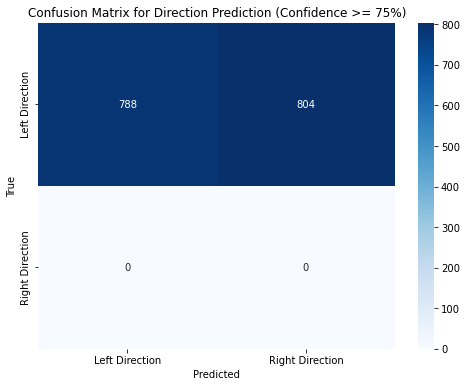

In [76]:
# Create empty confusion matrix
conf_matrix = np.zeros((2, 2))

for i in range(len(direction_prediction)):
    confidence_left = direction_prediction[i][0]
    confidence_right = 1 - direction_prediction[i][1]

    # Check if the prediction has 75% or greater confidence
    if max(confidence_left, confidence_right) >= 0.75:
        predicted_direction = np.argmax([confidence_left, confidence_right])
        true_direction = np.argmax(Y_dir[i])
        conf_matrix[true_direction, predicted_direction] += 1

# Define class labels
class_labels = ["Left Direction", "Right Direction"]

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Direction Prediction (Confidence >= 75%)')
plt.show()


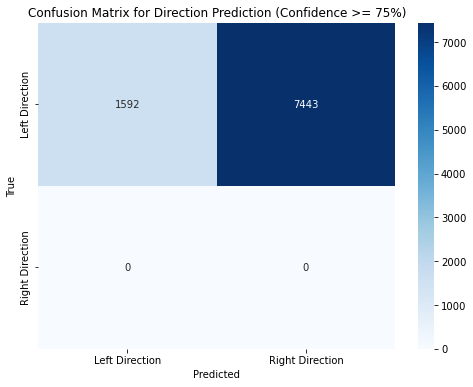

In [27]:
# Create empty confusion matrix
conf_matrix = np.zeros((2, 2))

for i in range(len(direction_prediction)):
    confidence_left = direction_prediction[i][0]
    confidence_right = direction_prediction[i][1]

    # Check if the prediction has 75% or greater confidence
    if max(confidence_left, confidence_right) >= 0.75:
        predicted_direction = np.argmax([confidence_left, confidence_right])
        true_direction = np.argmax(Y_dir[i])
        conf_matrix[true_direction, predicted_direction] += 1

# Define class labels
class_labels = ["Left Direction", "Right Direction"]

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Direction Prediction (Confidence >= 75%)')
plt.show()


In [ ]:
# Create empty confusion matrix
conf_matrix = np.zeros((2, 2))

for i in range(len(direction_prediction)):
    confidence_left = direction_prediction[i][0]
    confidence_right = direction_prediction[i][1]

    # Check if the prediction has 75% or greater confidence
    if max(confidence_left, confidence_right) >= 0.75:
        predicted_direction = np.argmax([confidence_left, confidence_right])
        true_direction = np.argmax(Y_dir[i])
        conf_matrix[true_direction, predicted_direction] += 1

# Define class labels
class_labels = ["Left Direction", "Right Direction"]

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Direction Prediction (Confidence >= 75%)')
plt.show()

## Evaluation for Step 3a (left)

In [42]:
coordinates_left_prediction = model_3_left.predict(X)

coordinates_right_prediction = model_3_right.predict(X)

/usr/lib/python3/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-08-27 12:46:41.562501: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_13/BiasAdd' id:1405 op device:{requested: '', assigned: ''} def:{{{node dense_13/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_13/MatMul, dense_13/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-08-27 12:50:07.440371: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_15/BiasAdd' id:1566 op device:{requested: '', assigned: ''} def:{{{node dense_15/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencie

In [ ]:
# coordinates_left_prediction_new = regression_model.predict(X)

# coordinates_right_prediction_new = regression_model.predict(X)

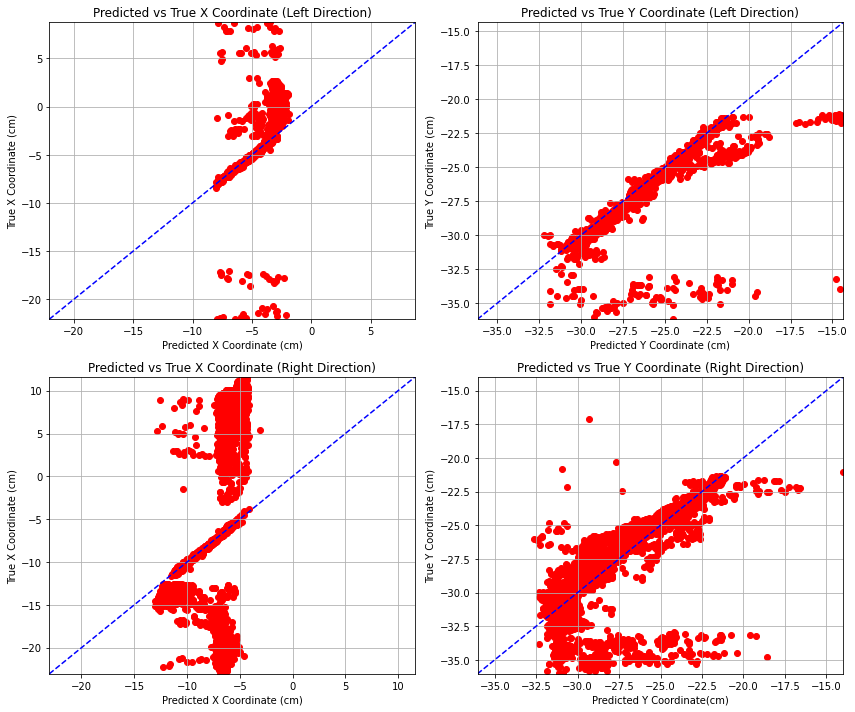

In [39]:
# Lists to store predicted and true coordinates
predicted_left_x = []
predicted_left_y = []
true_left_x = []
true_left_y = []

predicted_right_x = []
predicted_right_y = []
true_right_x = []
true_right_y = []



for i in range(len(X)):
    confidence_contact = contact_prediction[i][1] * 100
    left_confidence = direction_prediction[i][0]
    right_confidence = direction_prediction[i][1]

    # Check if the prediction has 75% or greater confidence for both contact and the specific direction
    if confidence_contact >= 0.75 and (left_confidence >= 0.75 or right_confidence >= 0.75):
        # predicted_x = regression_prediction[i][0]
        # predicted_y = regression_prediction[i][1]
        true_x, true_y = Y_coords[i]

        if left_confidence >= 0.75:
            predicted_x = coordinates_left_prediction[i][0]
            predicted_y = coordinates_left_prediction[i][1]
            predicted_left_x.append(predicted_x)
            predicted_left_y.append(predicted_y)
            true_left_x.append(true_x)
            true_left_y.append(true_y)

        if right_confidence >= 0.75:
            predicted_x = coordinates_right_prediction[i][0]
            predicted_y = coordinates_right_prediction[i][1]
            predicted_right_x.append(predicted_x)
            predicted_right_y.append(predicted_y)
            true_right_x.append(true_x)
            true_right_y.append(true_y)

# Plotting
plt.figure(figsize=(12, 10))


# Left Direction X Coordinate Plot
plt.subplot(2, 2, 1)
plt.scatter(predicted_left_x, true_left_x, color='red')
plt.title('Predicted vs True X Coordinate (Left Direction)')
plt.xlabel('Predicted X Coordinate (cm)')
plt.ylabel('True X Coordinate (cm)')
plt.grid()

min_x_left = min(predicted_left_x + true_left_x)
max_x_left = max(predicted_left_x + true_left_x)
plt.plot([min_x_left, max_x_left], [min_x_left, max_x_left], linestyle='--', color='blue')
plt.xlim(min_x_left, max_x_left)
plt.ylim(min_x_left, max_x_left)

# Left Direction Y Coordinate Plot
plt.subplot(2, 2, 2)
plt.scatter(predicted_left_y, true_left_y, color='red')
plt.title('Predicted vs True Y Coordinate (Left Direction)')
plt.xlabel('Predicted Y Coordinate (cm)')
plt.ylabel('True Y Coordinate (cm)')
plt.grid()

min_y_left = min(predicted_left_y + true_left_y)
max_y_left = max(predicted_left_y + true_left_y)
plt.plot([min_y_left, max_y_left], [min_y_left, max_y_left], linestyle='--', color='blue')
plt.xlim(min_y_left, max_y_left)
plt.ylim(min_y_left, max_y_left)

# Right Direction X Coordinate Plot
plt.subplot(2, 2, 3)
plt.scatter(predicted_right_x, true_right_x, color='red')
plt.title('Predicted vs True X Coordinate (Right Direction)')
plt.xlabel('Predicted X Coordinate (cm)')
plt.ylabel('True X Coordinate (cm)')
plt.grid()

min_x_right = min(predicted_right_x + true_right_x)
max_x_right = max(predicted_right_x + true_right_x)
plt.plot([min_x_right, max_x_right], [min_x_right, max_x_right], linestyle='--', color='blue')
plt.xlim(min_x_right, max_x_right)
plt.ylim(min_x_right, max_x_right)

# Right Direction Y Coordinate Plot
plt.subplot(2, 2, 4)
plt.scatter(predicted_right_y, true_right_y, color='red')
plt.title('Predicted vs True Y Coordinate (Right Direction)')
plt.xlabel('Predicted Y Coordinate(cm)')
plt.ylabel('True Y Coordinate (cm)')
plt.grid()

min_y_right = min(predicted_right_y + true_right_y)
max_y_right = max(predicted_right_y + true_right_y)
plt.plot([min_y_right, max_y_right], [min_y_right, max_y_right], linestyle='--', color='blue')
plt.xlim(min_y_right, max_y_right)
plt.ylim(min_y_right, max_y_right)


plt.tight_layout()
plt.show()


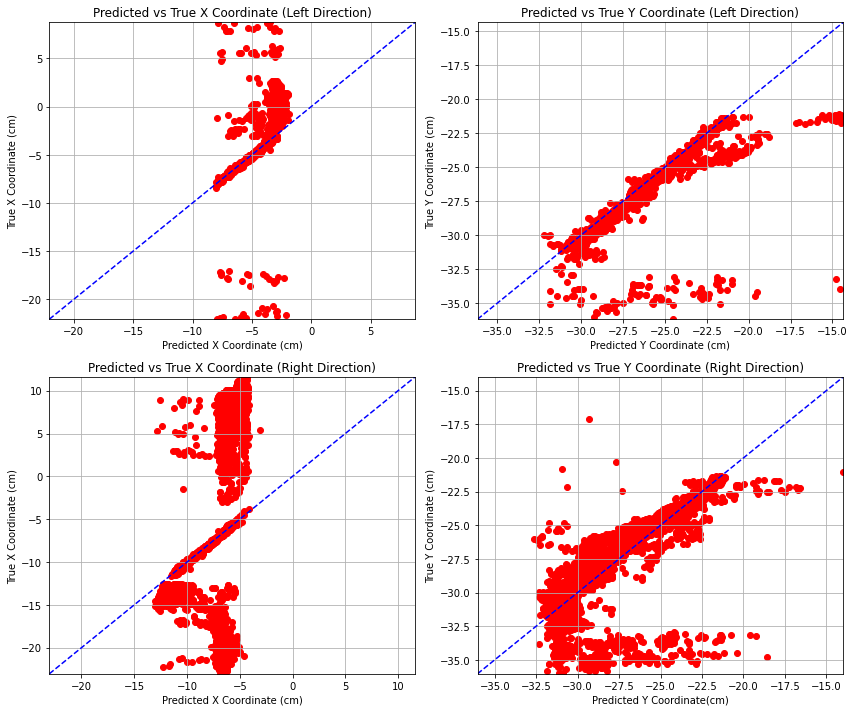

In [43]:
# Lists to store predicted and true coordinates
predicted_left_x = []
predicted_left_y = []
true_left_x = []
true_left_y = []

predicted_right_x = []
predicted_right_y = []
true_right_x = []
true_right_y = []



for i in range(len(X)):
    confidence_contact = contact_prediction[i][1] * 100
    left_confidence = direction_prediction[i][0]
    right_confidence = direction_prediction[i][1]

    # Check if the prediction has 75% or greater confidence for both contact and the specific direction
    if confidence_contact >= 0.75 and (left_confidence >= 0.75 or right_confidence >= 0.75):
        # predicted_x = regression_prediction[i][0]
        # predicted_y = regression_prediction[i][1]
        true_x, true_y = Y_coords[i]

        if left_confidence >= 0.75:
            predicted_x = coordinates_left_prediction[i][0]
            predicted_y = coordinates_left_prediction[i][1]
            predicted_left_x.append(predicted_x)
            predicted_left_y.append(predicted_y)
            true_left_x.append(true_x)
            true_left_y.append(true_y)

        if right_confidence >= 0.75:
            predicted_x = coordinates_right_prediction[i][0]
            predicted_y = coordinates_right_prediction[i][1]
            predicted_right_x.append(predicted_x)
            predicted_right_y.append(predicted_y)
            true_right_x.append(true_x)
            true_right_y.append(true_y)

# Plotting
plt.figure(figsize=(12, 10))


# Left Direction X Coordinate Plot
plt.subplot(2, 2, 1)
plt.scatter(predicted_left_x, true_left_x, color='red')
plt.title('Predicted vs True X Coordinate (Left Direction)')
plt.xlabel('Predicted X Coordinate (cm)')
plt.ylabel('True X Coordinate (cm)')
plt.grid()

min_x_left = min(predicted_left_x + true_left_x)
max_x_left = max(predicted_left_x + true_left_x)
plt.plot([min_x_left, max_x_left], [min_x_left, max_x_left], linestyle='--', color='blue')
plt.xlim(min_x_left, max_x_left)
plt.ylim(min_x_left, max_x_left)

# Left Direction Y Coordinate Plot
plt.subplot(2, 2, 2)
plt.scatter(predicted_left_y, true_left_y, color='red')
plt.title('Predicted vs True Y Coordinate (Left Direction)')
plt.xlabel('Predicted Y Coordinate (cm)')
plt.ylabel('True Y Coordinate (cm)')
plt.grid()

min_y_left = min(predicted_left_y + true_left_y)
max_y_left = max(predicted_left_y + true_left_y)
plt.plot([min_y_left, max_y_left], [min_y_left, max_y_left], linestyle='--', color='blue')
plt.xlim(min_y_left, max_y_left)
plt.ylim(min_y_left, max_y_left)

# Right Direction X Coordinate Plot
plt.subplot(2, 2, 3)
plt.scatter(predicted_right_x, true_right_x, color='red')
plt.title('Predicted vs True X Coordinate (Right Direction)')
plt.xlabel('Predicted X Coordinate (cm)')
plt.ylabel('True X Coordinate (cm)')
plt.grid()

min_x_right = min(predicted_right_x + true_right_x)
max_x_right = max(predicted_right_x + true_right_x)
plt.plot([min_x_right, max_x_right], [min_x_right, max_x_right], linestyle='--', color='blue')
plt.xlim(min_x_right, max_x_right)
plt.ylim(min_x_right, max_x_right)

# Right Direction Y Coordinate Plot
plt.subplot(2, 2, 4)
plt.scatter(predicted_right_y, true_right_y, color='red')
plt.title('Predicted vs True Y Coordinate (Right Direction)')
plt.xlabel('Predicted Y Coordinate(cm)')
plt.ylabel('True Y Coordinate (cm)')
plt.grid()

min_y_right = min(predicted_right_y + true_right_y)
max_y_right = max(predicted_right_y + true_right_y)
plt.plot([min_y_right, max_y_right], [min_y_right, max_y_right], linestyle='--', color='blue')
plt.xlim(min_y_right, max_y_right)
plt.ylim(min_y_right, max_y_right)


plt.tight_layout()
plt.show()


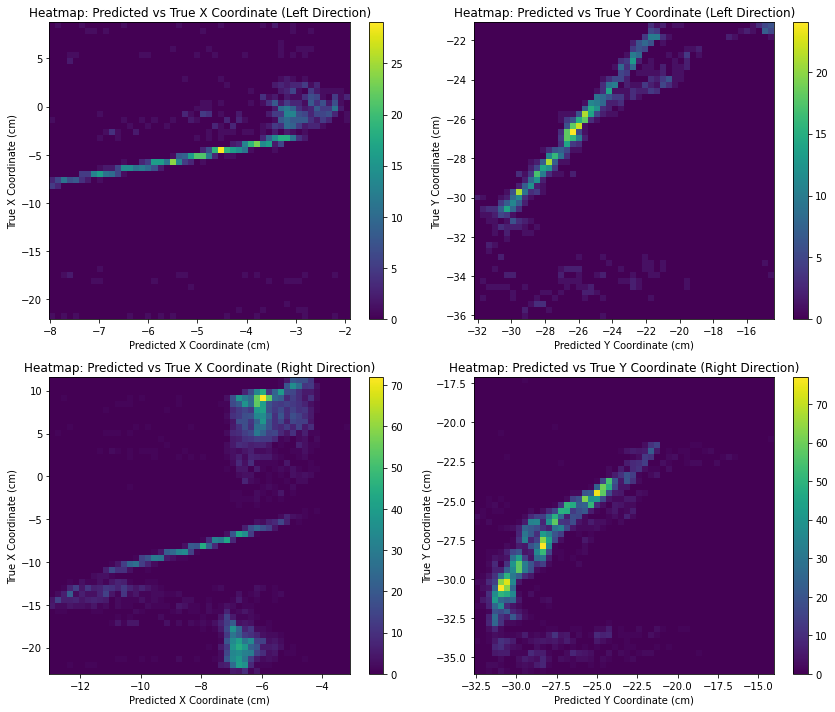

In [44]:

# Create heatmap for Left Direction X Coordinate
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.hist2d(predicted_left_x, true_left_x, bins=50, cmap='viridis')
plt.colorbar()
plt.title('Heatmap: Predicted vs True X Coordinate (Left Direction)')
plt.xlabel('Predicted X Coordinate (cm)')
plt.ylabel('True X Coordinate (cm)')

# Create heatmap for Left Direction Y Coordinate
plt.subplot(2, 2, 2)
plt.hist2d(predicted_left_y, true_left_y, bins=50, cmap='viridis')
plt.colorbar()
plt.title('Heatmap: Predicted vs True Y Coordinate (Left Direction)')
plt.xlabel('Predicted Y Coordinate (cm)')
plt.ylabel('True Y Coordinate (cm)')

# Create heatmap for Right Direction X Coordinate
plt.subplot(2, 2, 3)
plt.hist2d(predicted_right_x, true_right_x, bins=50, cmap='viridis')
plt.colorbar()
plt.title('Heatmap: Predicted vs True X Coordinate (Right Direction)')
plt.xlabel('Predicted X Coordinate (cm)')
plt.ylabel('True X Coordinate (cm)')

# Create heatmap for Right Direction Y Coordinate
plt.subplot(2, 2, 4)
plt.hist2d(predicted_right_y, true_right_y, bins=50, cmap='viridis')
plt.colorbar()
plt.title('Heatmap: Predicted vs True Y Coordinate (Right Direction)')
plt.xlabel('Predicted Y Coordinate (cm)')
plt.ylabel('True Y Coordinate (cm)')

plt.tight_layout()
plt.show()


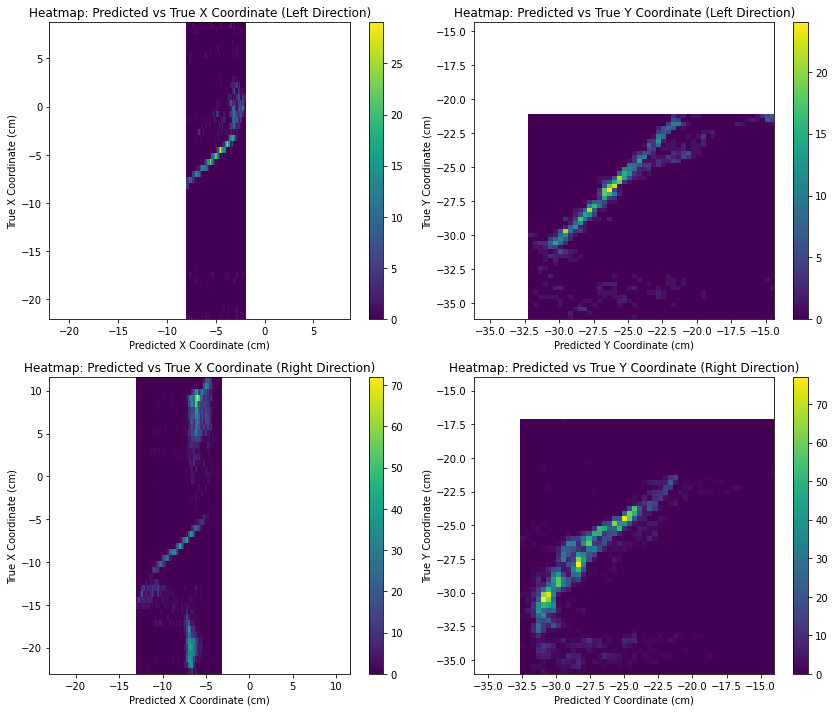

In [58]:
import matplotlib.pyplot as plt


# Create heatmap for Left Direction X Coordinate
plt.figure(figsize=(12, 10))

# Left Direction X Coordinate
plt.subplot(2, 2, 1)
plt.hist2d(predicted_left_x, true_left_x, bins=50, cmap='viridis')
plt.colorbar()
plt.title('Heatmap: Predicted vs True X Coordinate (Left Direction)')
plt.xlabel('Predicted X Coordinate (cm)')
plt.ylabel('True X Coordinate (cm)')

min_x_left = min(predicted_left_x + true_left_x)
max_x_left = max(predicted_left_x + true_left_x)
plt.xlim(min_x_left, max_x_left)  # Set the desired x-axis limits
plt.ylim(min_x_left, max_x_left)  # Set the desired y-axis limits

# Left Direction Y Coordinate
plt.subplot(2, 2, 2)
plt.hist2d(predicted_left_y, true_left_y, bins=50, cmap='viridis')
plt.colorbar()
plt.title('Heatmap: Predicted vs True Y Coordinate (Left Direction)')
plt.xlabel('Predicted Y Coordinate (cm)')
plt.ylabel('True Y Coordinate (cm)')
min_y_left = min(predicted_left_y + true_left_y)
max_y_left = max(predicted_left_y + true_left_y)
plt.xlim(min_y_left, max_y_left)  # Set the desired x-axis limits
plt.ylim(min_y_left, max_y_left)  # Set the desired y-axis limits

# Right Direction X Coordinate
plt.subplot(2, 2, 3)
plt.hist2d(predicted_right_x, true_right_x, bins=50, cmap='viridis')
plt.colorbar()
plt.title('Heatmap: Predicted vs True X Coordinate (Right Direction)')
plt.xlabel('Predicted X Coordinate (cm)')
plt.ylabel('True X Coordinate (cm)')
min_x_right = min(predicted_right_x + true_right_x)
max_x_right = max(predicted_right_x + true_right_x)
plt.xlim(min_x_right, max_x_right)  # Set the desired x-axis limits
plt.ylim(min_x_right, max_x_right)  # Set the desired y-axis limits

# Right Direction Y Coordinate
plt.subplot(2, 2, 4)
plt.hist2d(predicted_right_y, true_right_y, bins=50, cmap='viridis')
plt.colorbar()
plt.title('Heatmap: Predicted vs True Y Coordinate (Right Direction)')
plt.xlabel('Predicted Y Coordinate (cm)')
plt.ylabel('True Y Coordinate (cm)')
min_y_right = min(predicted_right_y + true_right_y)
max_y_right = max(predicted_right_y + true_right_y)
plt.xlim(min_y_right, max_y_right)  # Set the desired x-axis limits
plt.ylim(min_y_right, max_y_right)  # Set the desired y-axis limits

plt.tight_layout()
plt.show()


In [66]:
# Lists to store predicted and true coordinates
predicted_left_x = []
predicted_left_y = []
true_left_x = []
true_left_y = []

predicted_right_x = []
predicted_right_y = []
true_right_x = []
true_right_y = []



for i in range(len(X)):
    confidence_contact = contact_prediction[i][1] * 100
    left_confidence = direction_prediction[i][0]
    right_confidence = direction_prediction[i][1]

    # Check if the prediction has 75% or greater confidence for both contact and the specific direction
    if confidence_contact >= 0.75 and (left_confidence >= 0.75 or right_confidence >= 0.75):
        # predicted_x = regression_prediction[i][0]
        # predicted_y = regression_prediction[i][1]
        true_x, true_y = Y_coords[i]

        if left_confidence >= 0.75:
            predicted_x = coordinates_left_prediction[i][0]
            predicted_y = coordinates_left_prediction[i][1]
            predicted_left_x.append(predicted_x)
            predicted_left_y.append(predicted_y)
            true_left_x.append(true_x)
            true_left_y.append(true_y)

        if right_confidence >= 0.75:
            predicted_x = coordinates_right_prediction[i][0]
            predicted_y = coordinates_right_prediction[i][1]
            predicted_right_x.append(predicted_x)
            predicted_right_y.append(predicted_y)
            true_right_x.append(true_x)
            true_right_y.append(true_y)

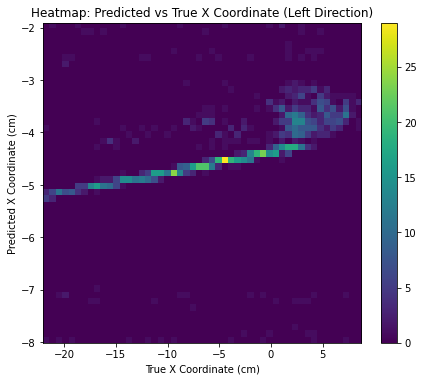

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Your data and calculations

# Create heatmap for Left Direction X Coordinate
plt.figure(figsize=(12, 10))

# Left Direction X Coordinate
plt.subplot(2, 2, 1)
H, xedges, yedges = np.histogram2d(predicted_left_x, true_left_x, bins=50)
extent = [yedges[0], yedges[-1], xedges[0], xedges[-1]]
plt.imshow(H.T, origin='lower', cmap='viridis', extent=extent, aspect='auto')

plt.colorbar()
plt.title('Heatmap: Predicted vs True X Coordinate (Left Direction)')
plt.xlabel('True X Coordinate (cm)')
plt.ylabel('Predicted X Coordinate (cm)')

# Repeat the same steps for other subplots...

plt.tight_layout()
plt.show()


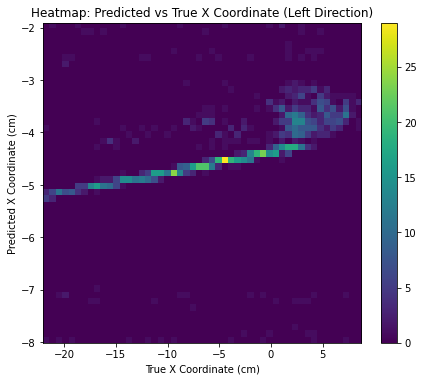

In [62]:
# Create heatmap for Left Direction X Coordinate
plt.figure(figsize=(12, 10))

# Calculate the data range for both x and y axes
x_range = np.concatenate((predicted_left_x, true_left_x))
y_range = np.concatenate((predicted_left_x, true_left_x))
data_range = [min(x_range), max(x_range)]

# Left Direction X Coordinate
plt.subplot(2, 2, 1)
H, xedges, yedges = np.histogram2d(predicted_left_x, true_left_x, bins=50)
extent = [yedges[0], yedges[-1], xedges[0], xedges[-1]]
plt.imshow(H.T, origin='lower', cmap='viridis', extent=extent, aspect='auto', vmin=0, vmax=H.max())

plt.colorbar()
plt.title('Heatmap: Predicted vs True X Coordinate (Left Direction)')
plt.xlabel('True X Coordinate (cm)')
plt.ylabel('Predicted X Coordinate (cm)')

# Repeat the same steps for other subplots...

plt.tight_layout()
plt.show()


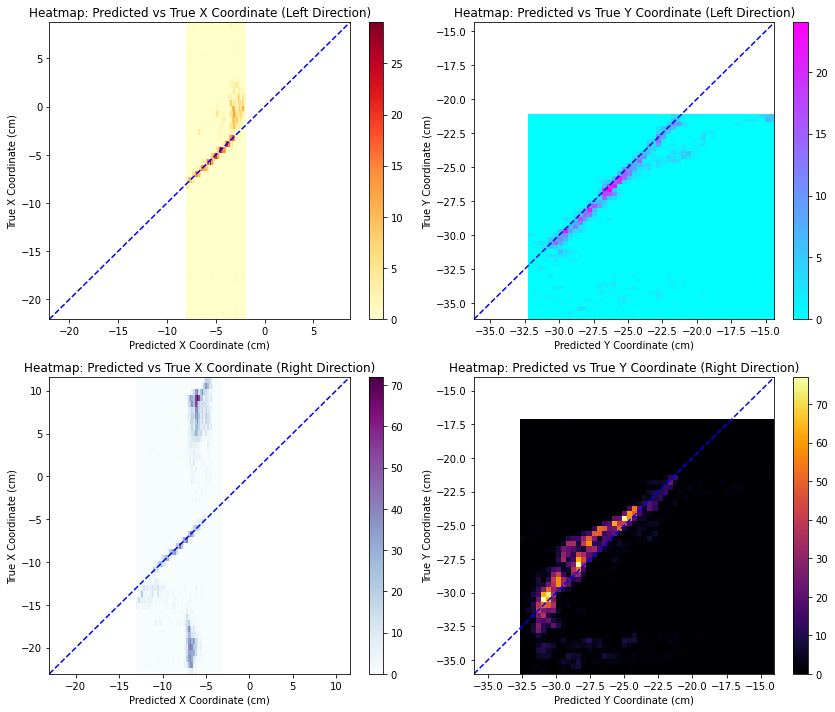

In [47]:
# Create heatmap for Left Direction X Coordinate with a different colormap
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.hist2d(predicted_left_x, true_left_x, bins=50, cmap='YlOrRd')  # Using YlOrRd colormap
plt.colorbar()
plt.title('Heatmap: Predicted vs True X Coordinate (Left Direction)')
plt.xlabel('Predicted X Coordinate (cm)')
plt.ylabel('True X Coordinate (cm)')

min_x_left = min(predicted_left_x + true_left_x)
max_x_left = max(predicted_left_x + true_left_x)
plt.plot([min_x_left, max_x_left], [min_x_left, max_x_left], linestyle='--', color='blue')
plt.xlim(min_x_left, max_x_left)
plt.ylim(min_x_left, max_x_left)

# Create heatmap for Left Direction Y Coordinate with a different colormap
plt.subplot(2, 2, 2)
plt.hist2d(predicted_left_y, true_left_y, bins=50, cmap='cool')  # Using cool colormap
plt.colorbar()
plt.title('Heatmap: Predicted vs True Y Coordinate (Left Direction)')
plt.xlabel('Predicted Y Coordinate (cm)')
plt.ylabel('True Y Coordinate (cm)')

min_y_left = min(predicted_left_y + true_left_y)
max_y_left = max(predicted_left_y + true_left_y)
plt.plot([min_y_left, max_y_left], [min_y_left, max_y_left], linestyle='--', color='blue')
plt.xlim(min_y_left, max_y_left)
plt.ylim(min_y_left, max_y_left)


# Create heatmap for Right Direction X Coordinate with a different colormap
plt.subplot(2, 2, 3)
plt.hist2d(predicted_right_x, true_right_x, bins=50, cmap='BuPu')  # Using BuPu colormap
plt.colorbar()
plt.title('Heatmap: Predicted vs True X Coordinate (Right Direction)')
plt.xlabel('Predicted X Coordinate (cm)')
plt.ylabel('True X Coordinate (cm)')

min_x_right = min(predicted_right_x + true_right_x)
max_x_right = max(predicted_right_x + true_right_x)
plt.plot([min_x_right, max_x_right], [min_x_right, max_x_right], linestyle='--', color='blue')
plt.xlim(min_x_right, max_x_right)
plt.ylim(min_x_right, max_x_right)


# Create heatmap for Right Direction Y Coordinate with a different colormap
plt.subplot(2, 2, 4)
plt.hist2d(predicted_right_y, true_right_y, bins=50, cmap='inferno')  # Using inferno colormap
plt.colorbar()
plt.title('Heatmap: Predicted vs True Y Coordinate (Right Direction)')
plt.xlabel('Predicted Y Coordinate (cm)')
plt.ylabel('True Y Coordinate (cm)')
min_y_right = min(predicted_right_y + true_right_y)
max_y_right = max(predicted_right_y + true_right_y)
plt.plot([min_y_right, max_y_right], [min_y_right, max_y_right], linestyle='--', color='blue')
plt.xlim(min_y_right, max_y_right)
plt.ylim(min_y_right, max_y_right)

plt.tight_layout()
plt.show()

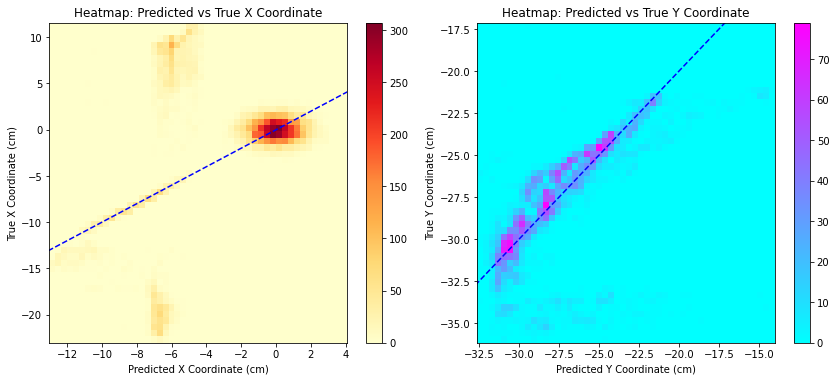

In [98]:

# Create heatmap for Left Direction X Coordinate with a different colormap
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
heatmap_x = plt.hist2d(predicted_x, true_x, bins=50, cmap='YlOrRd')  # Using YlOrRd colormap
plt.colorbar()
plt.title('Heatmap: Predicted vs True X Coordinate')
plt.xlabel('Predicted X Coordinate (cm)')
plt.ylabel('True X Coordinate (cm)')

min_x = min(min(predicted_x), min(true_x))
max_x = max(max(predicted_x), max(true_x))
plt.plot([min_x, max_x], [min_x, max_x], linestyle='--', color='blue')

# Create heatmap for Left Direction Y Coordinate with a different colormap
plt.subplot(2, 2, 2)
heatmap_y = plt.hist2d(predicted_y, true_y, bins=50, cmap='cool')  # Using cool colormap
plt.colorbar()
plt.title('Heatmap: Predicted vs True Y Coordinate')
plt.xlabel('Predicted Y Coordinate (cm)')
plt.ylabel('True Y Coordinate (cm)')

min_y = min(min(predicted_y), min(true_y))
max_y = max(max(predicted_y), max(true_y))
plt.plot([min_y, max_y], [min_y, max_y], linestyle='--', color='blue')


plt.tight_layout()
plt.show()


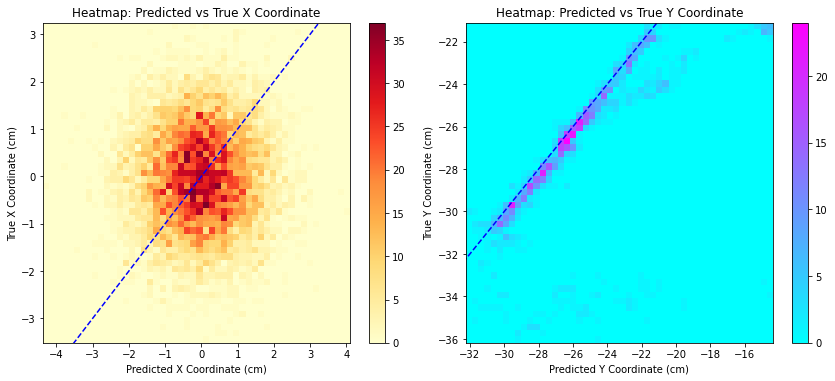

In [95]:
# import matplotlib.pyplot as plt


# # Create heatmap for Left Direction X Coordinate with a different colormap
# plt.figure(figsize=(12, 10))
# plt.subplot(2, 2, 1)
# heatmap_left_x = plt.hist2d(predicted_left_x, true_left_x, bins=50, cmap='YlOrRd')  # Using YlOrRd colormap
# plt.colorbar()
# plt.title('Heatmap: Predicted vs True X Coordinate')
# plt.xlabel('Predicted X Coordinate (cm)')
# plt.ylabel('True X Coordinate (cm)')

# min_x_left = min(min(predicted_left_x), min(true_left_x))
# max_x_left = max(max(predicted_left_x), max(true_left_x))
# plt.plot([min_x_left, max_x_left], [min_x_left, max_x_left], linestyle='--', color='blue')

# # Create heatmap for Left Direction Y Coordinate with a different colormap
# plt.subplot(2, 2, 2)
# heatmap_left_y = plt.hist2d(predicted_left_y, true_left_y, bins=50, cmap='cool')  # Using cool colormap
# plt.colorbar()
# plt.title('Heatmap: Predicted vs True Y Coordinate')
# plt.xlabel('Predicted Y Coordinate (cm)')
# plt.ylabel('True Y Coordinate (cm)')

# min_y_left = min(min(predicted_left_y), min(true_left_y))
# max_y_left = max(max(predicted_left_y), max(true_left_y))
# plt.plot([min_y_left, max_y_left], [min_y_left, max_y_left], linestyle='--', color='blue')


# plt.tight_layout()
# plt.show()


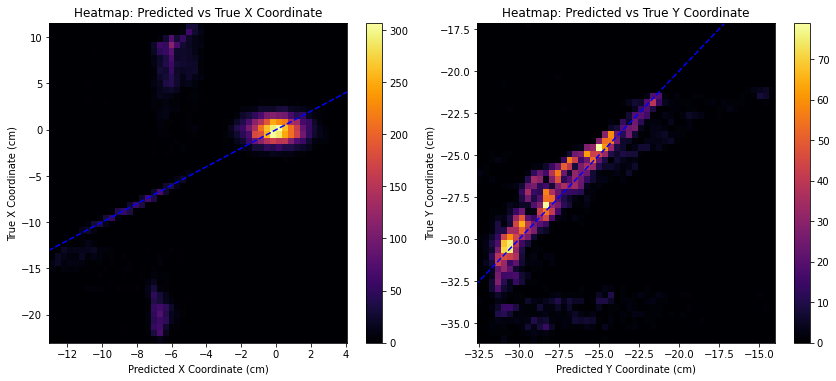

In [97]:
############## This is for combined left and right direction results ####################3

# Create heatmap for Left Direction X Coordinate with a different colormap
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
heatmap_x = plt.hist2d(predicted_x, true_x, bins=50, cmap='inferno')  # Using YlOrRd colormap
plt.colorbar()
plt.title('Heatmap: Predicted vs True X Coordinate')
plt.xlabel('Predicted X Coordinate (cm)')
plt.ylabel('True X Coordinate (cm)')

min_x = min(min(predicted_x), min(true_x))
max_x = max(max(predicted_x), max(true_x))
plt.plot([min_x, max_x], [min_x, max_x], linestyle='--', color='blue')

# Create heatmap for Left Direction Y Coordinate with a different colormap
plt.subplot(2, 2, 2)
heatmap_y = plt.hist2d(predicted_y, true_y, bins=50, cmap='inferno')  # Using cool colormap
plt.colorbar()
plt.title('Heatmap: Predicted vs True Y Coordinate')
plt.xlabel('Predicted Y Coordinate (cm)')
plt.ylabel('True Y Coordinate (cm)')

min_y = min(min(predicted_y), min(true_y))
max_y = max(max(predicted_y), max(true_y))
plt.plot([min_y, max_y], [min_y, max_y], linestyle='--', color='blue')


plt.tight_layout()
plt.show()


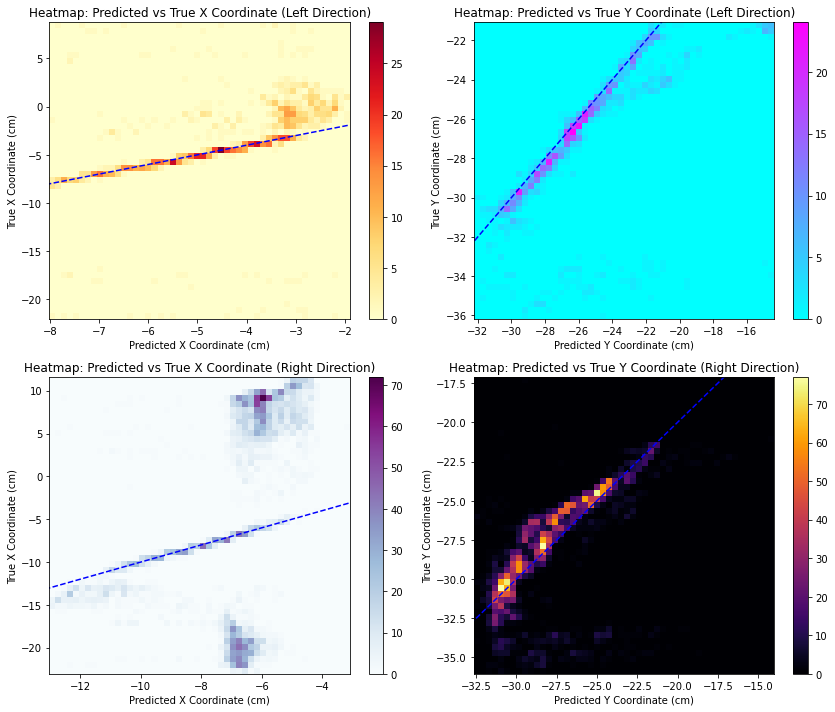

In [49]:
# Create heatmap for Left Direction X Coordinate with a different colormap
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
heatmap_left_x = plt.hist2d(predicted_left_x, true_left_x, bins=50, cmap='YlOrRd')  # Using YlOrRd colormap
plt.colorbar()
plt.title('Heatmap: Predicted vs True X Coordinate (Left Direction)')
plt.xlabel('Predicted X Coordinate (cm)')
plt.ylabel('True X Coordinate (cm)')

min_x_left = min(min(predicted_left_x), min(true_left_x))
max_x_left = max(max(predicted_left_x), max(true_left_x))
plt.plot([min_x_left, max_x_left], [min_x_left, max_x_left], linestyle='--', color='blue')

# Create heatmap for Left Direction Y Coordinate with a different colormap
plt.subplot(2, 2, 2)
heatmap_left_y = plt.hist2d(predicted_left_y, true_left_y, bins=50, cmap='cool')  # Using cool colormap
plt.colorbar()
plt.title('Heatmap: Predicted vs True Y Coordinate (Left Direction)')
plt.xlabel('Predicted Y Coordinate (cm)')
plt.ylabel('True Y Coordinate (cm)')

min_y_left = min(min(predicted_left_y), min(true_left_y))
max_y_left = max(max(predicted_left_y), max(true_left_y))
plt.plot([min_y_left, max_y_left], [min_y_left, max_y_left], linestyle='--', color='blue')

# Create heatmap for Right Direction X Coordinate with a different colormap
plt.subplot(2, 2, 3)
heatmap_right_x = plt.hist2d(predicted_right_x, true_right_x, bins=50, cmap='BuPu')  # Using BuPu colormap
plt.colorbar()
plt.title('Heatmap: Predicted vs True X Coordinate (Right Direction)')
plt.xlabel('Predicted X Coordinate (cm)')
plt.ylabel('True X Coordinate (cm)')

min_x_right = min(min(predicted_right_x), min(true_right_x))
max_x_right = max(max(predicted_right_x), max(true_right_x))
plt.plot([min_x_right, max_x_right], [min_x_right, max_x_right], linestyle='--', color='blue')

# Create heatmap for Right Direction Y Coordinate with a different colormap
plt.subplot(2, 2, 4)
heatmap_right_y = plt.hist2d(predicted_right_y, true_right_y, bins=50, cmap='inferno')  # Using inferno colormap
plt.colorbar()
plt.title('Heatmap: Predicted vs True Y Coordinate (Right Direction)')
plt.xlabel('Predicted Y Coordinate (cm)')
plt.ylabel('True Y Coordinate (cm)')

min_y_right = min(min(predicted_right_y), min(true_right_y))
max_y_right = max(max(predicted_right_y), max(true_right_y))
plt.plot([min_y_right, max_y_right], [min_y_right, max_y_right], linestyle='--', color='blue')

plt.tight_layout()
plt.show()


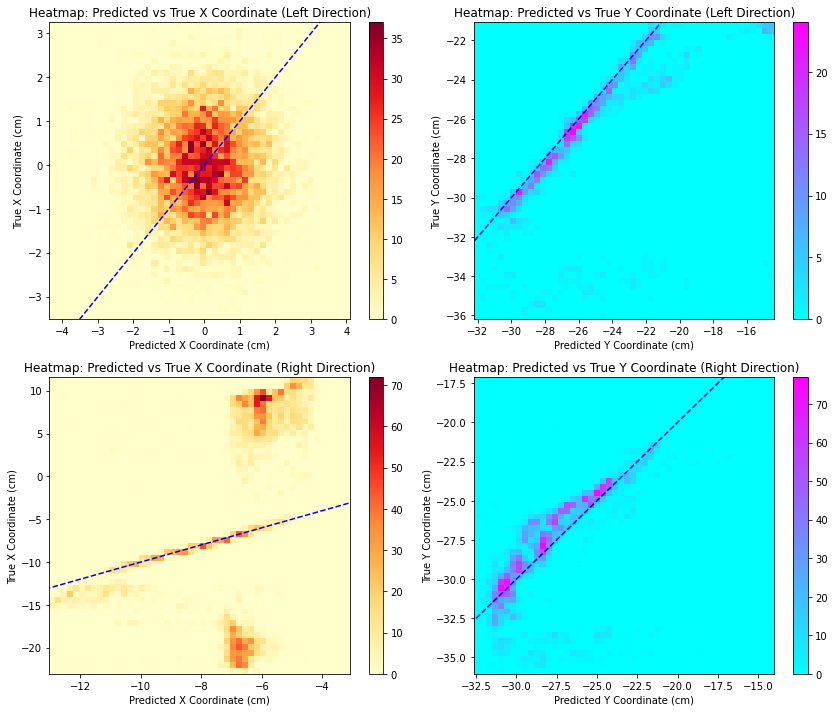

In [94]:

# Create heatmap for Left Direction X Coordinate with a different colormap
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
heatmap_left_x = plt.hist2d(predicted_left_x, true_left_x, bins=50, cmap='YlOrRd')  # Using YlOrRd colormap
plt.colorbar()
plt.title('Heatmap: Predicted vs True X Coordinate (Left Direction)')
plt.xlabel('Predicted X Coordinate (cm)')
plt.ylabel('True X Coordinate (cm)')

min_x_left = min(min(predicted_left_x), min(true_left_x))
max_x_left = max(max(predicted_left_x), max(true_left_x))
plt.plot([min_x_left, max_x_left], [min_x_left, max_x_left], linestyle='--', color='blue')

# Create heatmap for Left Direction Y Coordinate with a different colormap
plt.subplot(2, 2, 2)
heatmap_left_y = plt.hist2d(predicted_left_y, true_left_y, bins=50, cmap='cool')  # Using cool colormap
plt.colorbar()
plt.title('Heatmap: Predicted vs True Y Coordinate (Left Direction)')
plt.xlabel('Predicted Y Coordinate (cm)')
plt.ylabel('True Y Coordinate (cm)')

min_y_left = min(min(predicted_left_y), min(true_left_y))
max_y_left = max(max(predicted_left_y), max(true_left_y))
plt.plot([min_y_left, max_y_left], [min_y_left, max_y_left], linestyle='--', color='blue')

# Create heatmap for Right Direction X Coordinate with a different colormap
plt.subplot(2, 2, 3)
heatmap_right_x = plt.hist2d(predicted_right_x, true_right_x, bins=50, cmap='YlOrRd')  # Using BuPu colormap
plt.colorbar()
plt.title('Heatmap: Predicted vs True X Coordinate (Right Direction)')
plt.xlabel('Predicted X Coordinate (cm)')
plt.ylabel('True X Coordinate (cm)')

min_x_right = min(min(predicted_right_x), min(true_right_x))
max_x_right = max(max(predicted_right_x), max(true_right_x))
plt.plot([min_x_right, max_x_right], [min_x_right, max_x_right], linestyle='--', color='blue')

# Create heatmap for Right Direction Y Coordinate with a different colormap
plt.subplot(2, 2, 4)
heatmap_right_y = plt.hist2d(predicted_right_y, true_right_y, bins=50, cmap='cool')  # Using inferno colormap
plt.colorbar()
plt.title('Heatmap: Predicted vs True Y Coordinate (Right Direction)')
plt.xlabel('Predicted Y Coordinate (cm)')
plt.ylabel('True Y Coordinate (cm)')

min_y_right = min(min(predicted_right_y), min(true_right_y))
max_y_right = max(max(predicted_right_y), max(true_right_y))
plt.plot([min_y_right, max_y_right], [min_y_right, max_y_right], linestyle='--', color='blue')

plt.tight_layout()
plt.show()

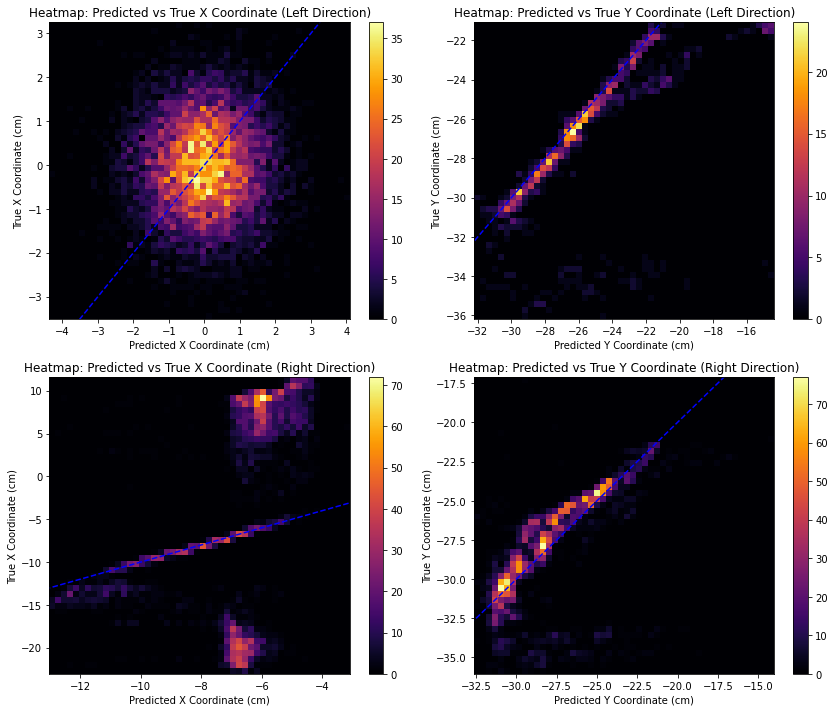

In [93]:
# Create heatmap for Left Direction X Coordinate with a different colormap
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
heatmap_left_x = plt.hist2d(predicted_left_x, true_left_x, bins=50, cmap='inferno')  # Using YlOrRd colormap
plt.colorbar()
plt.title('Heatmap: Predicted vs True X Coordinate (Left Direction)')
plt.xlabel('Predicted X Coordinate (cm)')
plt.ylabel('True X Coordinate (cm)')

min_x_left = min(min(predicted_left_x), min(true_left_x))
max_x_left = max(max(predicted_left_x), max(true_left_x))
plt.plot([min_x_left, max_x_left], [min_x_left, max_x_left], linestyle='--', color='blue')

# Create heatmap for Left Direction Y Coordinate with a different colormap
plt.subplot(2, 2, 2)
heatmap_left_y = plt.hist2d(predicted_left_y, true_left_y, bins=50, cmap='inferno')  # Using cool colormap
plt.colorbar()
plt.title('Heatmap: Predicted vs True Y Coordinate (Left Direction)')
plt.xlabel('Predicted Y Coordinate (cm)')
plt.ylabel('True Y Coordinate (cm)')

min_y_left = min(min(predicted_left_y), min(true_left_y))
max_y_left = max(max(predicted_left_y), max(true_left_y))
plt.plot([min_y_left, max_y_left], [min_y_left, max_y_left], linestyle='--', color='blue')

# Create heatmap for Right Direction X Coordinate with a different colormap
plt.subplot(2, 2, 3)
heatmap_right_x = plt.hist2d(predicted_right_x, true_right_x, bins=50, cmap='inferno')  # Using BuPu colormap
plt.colorbar()
plt.title('Heatmap: Predicted vs True X Coordinate (Right Direction)')
plt.xlabel('Predicted X Coordinate (cm)')
plt.ylabel('True X Coordinate (cm)')

min_x_right = min(min(predicted_right_x), min(true_right_x))
max_x_right = max(max(predicted_right_x), max(true_right_x))
plt.plot([min_x_right, max_x_right], [min_x_right, max_x_right], linestyle='--', color='blue')

# Create heatmap for Right Direction Y Coordinate with a different colormap
plt.subplot(2, 2, 4)
heatmap_right_y = plt.hist2d(predicted_right_y, true_right_y, bins=50, cmap='inferno')  # Using inferno colormap
plt.colorbar()
plt.title('Heatmap: Predicted vs True Y Coordinate (Right Direction)')
plt.xlabel('Predicted Y Coordinate (cm)')
plt.ylabel('True Y Coordinate (cm)')

min_y_right = min(min(predicted_right_y), min(true_right_y))
max_y_right = max(max(predicted_right_y), max(true_right_y))
plt.plot([min_y_right, max_y_right], [min_y_right, max_y_right], linestyle='--', color='blue')

plt.tight_layout()
plt.show()

In [85]:
predicted_x = np.concatenate((predicted_left_x, predicted_right_x), axis=0)
predicted_y = np.concatenate((predicted_left_y, predicted_right_y), axis=0)

true_x = np.concatenate((true_left_x, true_right_x), axis=0)
true_y = np.concatenate((true_left_y, true_right_y), axis=0)

In [72]:
# Lists to store predicted and true coordinates
predicted_left_x = []
predicted_left_y = []
true_left_x = []
true_left_y = []

predicted_right_x = []
predicted_right_y = []
true_right_x = []
true_right_y = []



for i in range(len(X)):
    confidence_contact = contact_prediction[i][1] * 100
    left_confidence = direction_prediction[i][0]
    right_confidence = direction_prediction[i][1]

    # Check if the prediction has 75% or greater confidence for both contact and the specific direction
    if confidence_contact >= 0.75 and (left_confidence >= 0.75 or right_confidence >= 0.75):
        # predicted_x = regression_prediction[i][0]
        # predicted_y = regression_prediction[i][1]
        true_x, true_y = Y_coords[i]

        if left_confidence >= 0.75:
            predicted_x = coordinates_left_prediction[i][0]
            predicted_y = coordinates_left_prediction[i][1]
            predicted_left_x.append(predicted_x)
            predicted_left_y.append(predicted_y)
            true_left_x.append(true_x)
            true_left_y.append(true_y)

        if right_confidence >= 0.75:
            predicted_x = coordinates_right_prediction[i][0]
            predicted_y = coordinates_right_prediction[i][1]
            predicted_right_x.append(predicted_x)
            predicted_right_y.append(predicted_y)
            true_right_x.append(true_x)
            true_right_y.append(true_y)

In [81]:
print(max(predicted_left_x))
print(max(true_left_x))
print(min(predicted_left_x))
print(min(true_left_x))

-1.9036101
8.744826087776023
-8.011598
-22.064372988884795


## Evaluation for Step 3b (right)

In [ ]:
# coordinates_right_prediction = model_3_right.predict(X)

In [5]:
sess.close()
tf.reset_default_graph()
